In [1]:
import math

import scipy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline
"""
import osmnx as ox
ox.config(log_console=True, use_cache=True)
ox.__version__
"""

'\nimport osmnx as ox\nox.config(log_console=True, use_cache=True)\nox.__version__\n'

In [20]:
def create_pdf_network():
    graph = nx.Graph()
    graph.add_edge(1, 4, weight=1)
    graph.add_edge(1, 2, weight=1)
    graph.add_edge(4, 2, weight=1)
    graph.add_edge(2, 3, weight=1)
    graph.add_edge(4, 3, weight=1)
    graph.add_edge(3, 6, weight=1)
    graph.add_edge(3, 7, weight=1)
    graph.add_edge(3, 5, weight=1)
    graph.add_edge(6, 7, weight=1)
    
    graph = graph.to_undirected()
    graph.remove_edges_from(graph.selfloop_edges())
    
    return graph



In [98]:
def visualize(G, big=False):
    if big:
        plt.figure(figsize=(12, 8))
    labels = G.nodes()
    pos=nx.spring_layout(G)
    nx.draw_networkx(G, with_labels=True, nodecolor='r', edge_color='b', 
            node_size=500, font_size=16, pos=pos, width=6)   # default spring_layout
    new_labels = {(x,y): z["weight"] for x, y, z in graph.edges(data=True)}
    # use default edge labels
    nx.draw_networkx_edge_labels(G,pos, edge_labels=new_labels)
    plt.show(True)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q1

## a) Degree distribution,

In [99]:
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

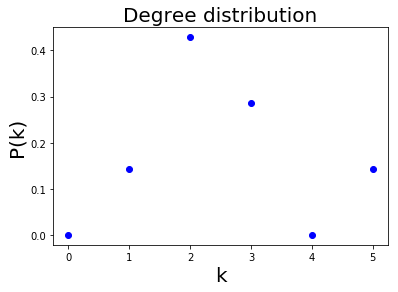

In [100]:
ks, Pk = degree_distribution(graph)

fig = plt.subplot(1,1,1)
#fig.set_xscale('log')
#fig.set_yscale('log')
plt.plot(ks,Pk,'bo')
plt.xlabel("k", fontsize=20)
plt.ylabel("P(k)", fontsize=20)
plt.title("Degree distribution", fontsize=20)
#plt.grid(True)
plt.savefig('degree_dist.eps') #save the figure into a file
plt.show(True)



## 1b) Local clustering coefficient

In [101]:
vcc = []
for i in graph.nodes():
    vcc.append(nx.clustering(graph, i))
vcc= np.array(vcc)
print('Clustering of all nodes:', vcc)

Clustering of all nodes: [1.         0.66666667 0.66666667 0.2        1.         1.
 0.        ]


## c) Transitivity

In [102]:
CC = (nx.transitivity(graph)) 
print("Transitivity = ","%3.4f"%CC)

Transitivity =  0.4737


## d) Distance matrix,

In [103]:
nx.floyd_warshall_numpy(graph, nodelist=sorted(graph.nodes))

matrix([[0., 1., 2., 1., 3., 3., 3.],
        [1., 0., 1., 1., 2., 2., 2.],
        [2., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 0., 2., 2., 2.],
        [3., 2., 1., 2., 0., 2., 2.],
        [3., 2., 1., 2., 2., 0., 1.],
        [3., 2., 1., 2., 2., 1., 0.]])

## e) Entropy of the degree distribution

In [104]:
def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H



In [105]:
shannon_entropy(graph)

1.8423709931771088

## f) Second moment of the degree distribution.

In [106]:
def momment_of_degree_distribution2(G,m):
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/N
    return M


In [107]:
k2 = momment_of_degree_distribution2(graph, 2)
print("Second moment of the degree distribution = ", k2)

Second moment of the degree distribution =  8.0




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q2

In [108]:
def graph_to_undirected(graph, sum_edges=True, testing=False):   
    """Converts a graph to it's undirecte version. 
    If not sum_edges, we simply use the value of the 'last' edge when iterating.
    Otherwise, we sum the value of the incoming/outcoming edge.
    """
    if sum_edges:
        new_g = nx.Graph()
        new_g.add_edges_from(graph.edges, weight=0)
        for u, v in graph.edges:
            new_g[u][v]['weight'] += graph[u][v]['weight']
        new_g
    else:
        new_g = graph.to_undirected()

    # Quick test to show our implementation is correct
    if testing:
        graph = nx.DiGraph()
        graph.add_edge(2, 1, weight=1)
        graph.add_edge(1, 2, weight=2)
        print("Before:")
        visualize(graph)
        print("After:")
        visualize(graph_to_undirected(graph))
    
    return new_g

def graph_to_unweighted(graph, min_weight=1, testing=False):
    """Converts a graph to it's unweighted version. 
    Any edge with weight >= min_weight is included.
    """
    Gnew = nx.Graph()
    for (u,v,w) in graph.edges(data=True):
        if w['weight'] >= min_weight :
            Gnew.add_edge(u, v)
    
    if testing:
        graph = nx.Graph()
        graph.add_edge(1, 2, weight=1)
        graph.add_edge(2, 3, weight=2)
        graph.add_edge(3, 4, weight=3)
        print("Before:")
        visualize(graph)
        print("After:")
        visualize(graph_to_unweighted(graph, 3))

    return Gnew

    
def read_lesmis(filename, digraph=True):   
    """Reads the lesmis dataset"""
    # Read the directed network
    graph = nx.read_edgelist(filename, nodetype=int, data=(('weight',float),),
                            create_using=nx.DiGraph) 
    return graph

Weighted: 


/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


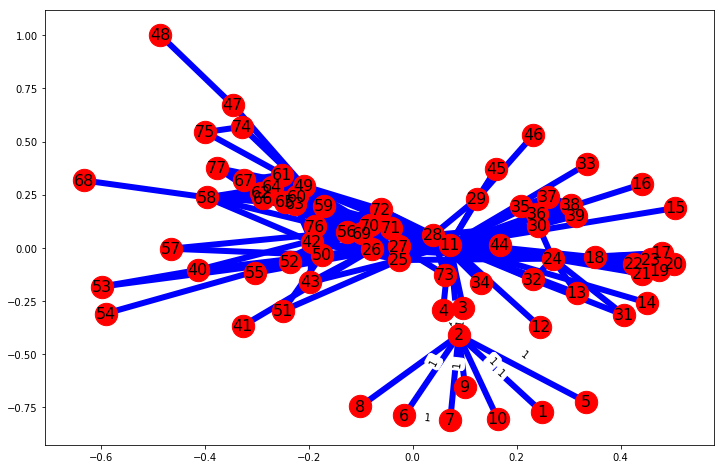

Unweighted: 


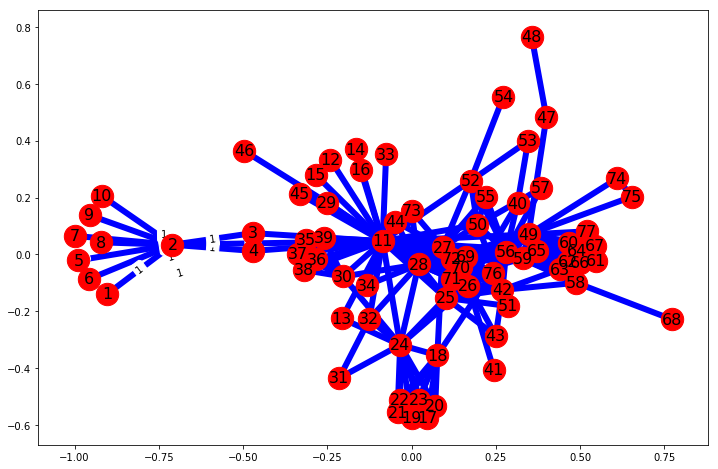

In [110]:
g_lesmis = read_lesmis("data/nets/lesmis.txt")
g_lesmis = graph_to_undirected(g_lesmis, sum_edges=True)
print("Weighted: ")
visualize(g_lesmis, big=True)
print("Unweighted: ")
visualize(graph_to_unweighted(g_lesmis), big=True)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q3

# TODO

In [17]:
G = graph

In [18]:
# let networkx return the adjacency matrix A
A = nx.adj_matrix(G)
A = A.todense()
A = np.array(A, dtype = np.float64)
# let's evaluate the degree matrix D
D = np.diag(np.sum(A, axis=0))
# ...and the transition matrix T
T = np.dot(np.linalg.inv(D),A)

# let's define the random walk length, say 10
walkLength = 10
# define the starting node, say the 0-th
#p = np.zeros([1, 0, 0, 0, 0]).reshape(-1,1)
p = np.zeros(T.shape[1]).reshape(-1,1)
p[0] = 1
visited = list()
for k in range(walkLength):
    # evaluate the next state vector
    p = np.dot(T,p)
    # choose the node with higher probability as the visited node
    visited.append(np.argmax(p))

In [19]:
visited

[1, 0, 1, 0, 1, 0, 1, 0, 2, 0]



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q4

In [22]:
graph = create_pdf_network()



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q5



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q6



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q7



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q8



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q9



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Q10